In [1]:
%matplotlib inline
import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException
from ClientCredentials import client_id, client_secret
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Logging in
username = "113586775"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
# Which tracks was released in 2018?
release_date = []
artist_name = []
track_name = []
popularity = []
track_id = []

for i in range(0,10000,50):
    try:
        track_results = spotify.search(q='year:2018', type='track', limit=50, offset=i)
    except SpotifyException:
        print(i)
        break
        # Ignore 404 HTTP error
    for t in track_results['tracks']['items']:
        release_date.append(t['album']['release_date'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])


HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
2000


In [4]:
# Creating a dataframe
track_df = pd.DataFrame(
    {
        'release_date': release_date,
        'artist_name': artist_name,
        'track_name': track_name,
        'track_id': track_id,
        'popularity': popularity
    }
)
track_df['release_date'] = pd.to_datetime(track_df['release_date'])
track_df.sort_values(by=['release_date', 'artist_name', 'track_name'], inplace=True, ignore_index=True)
# ignore_index=True: updates the indices of the dataframe

print(f"Dataframe shape: {track_df.shape}")
print("\n", track_df.head(10))
print("\n", track_df.describe())
print("\n", track_df.dtypes)

Dataframe shape: (2000, 5)

   release_date     artist_name                track_name                track_id  popularity
0   2018-01-01     Beach Bunny                    Sports  77G0k1La0c5Dw8bAFANcyp          70
1   2018-01-01     Beach Bunny                    Sports  77G0k1La0c5Dw8bAFANcyp          70
2   2018-01-01        Cavetown                      Fool  7asyVbwQE7IbA3x2be7bdI          70
3   2018-01-01        Cavetown                     Green  2PfkfkaO9okAk0OxC4ggy5          63
4   2018-01-01        Cavetown                 Lemon Boy  3Yvk0ZLxMlt6ioasvdN6vB          71
5   2018-01-01     Riley Green          Bury Me In Dixie  7KFbFqfBxqRtSSwkA874iv          63
6   2018-01-01     Riley Green          Bury Me In Dixie  7KFbFqfBxqRtSSwkA874iv          63
7   2018-01-03        MOMOLAND               BBoom BBoom  3BPoSr2pO34Aan6alFfVto          68
8   2018-01-04  Kendrick Lamar  All The Stars (with SZA)  66kQ7wr4d2LwwSjr7HXcyr          62
9   2018-01-04       RichaadEB           

No. artists:  833


array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

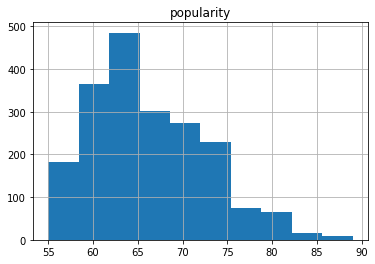

In [5]:
print("No. artists: ", track_df['artist_name'].nunique())

track_df.hist(column='popularity')

In [6]:
# Which playlists do I have?
playlists = spotify.user_playlists(username)
print("Type: ", type(playlists))
print("Keys: ", playlists.keys())
print()

playlist_name = []
playlist_ntracks = []
playlist_id = []

for p in playlists['items']:
    playlist_name.append(p['name'])
    playlist_ntracks.append(p['tracks']['total'])
    playlist_id.append(p['id'])

playlist_df = pd.DataFrame(
    {'n_tracks': playlist_ntracks, 'id': playlist_id}, 
    index=playlist_name
    )
print(playlist_df)
print("Number of tracks in Favorites-playlist: ", playlist_df['n_tracks']['Favorites'])

Type:  <class 'dict'>
Keys:  dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

                                n_tracks                      id
Favorites                           1031  2tvrDqnp3vJd6l6Cw38bVZ
Queen and other classics             105  367BXl0oqvDSbBu34T6OBH
John Mayer                           211  4h69xgBmpi8WnrCzNG0saL
Global Top 50                         50  37i9dQZEVXbMDoHDwVN2tF
Rock                                  81  2k19D3M2QSz3sdS0MzocSs
Party                                478  1Vs71OxUMfNXTLtp4USgTA
Blues                                 49  5na5MdXxNrFa7JUUwg14qP
Piano                                 32  4qa6CoQZqpUun4Divl1Cjg
Rock du kender                       152  37i9dQZF1DXcSNirXzsHRX
Tolkiens The Lord of the Ri...        78  4F3VK81yAvFlVquazfxVLG
Number of tracks in Favorites-playlist:  1031


In [7]:
artists = []
unique_artists = []
track_name = []
release_date = []
popularity = []
track_id = []

for i in range(0, playlist_df['n_tracks'].Favorites, 100):
    track_results = spotify.user_playlist_tracks(username, playlist_df['id'].Favorites, offset=i, limit=100)
    
    for track in track_results['items']:
        artists.append({artist['name'] for artist in track['track']['artists']})
        
        for artist in track['track']['artists']:
            if artist['name'] not in unique_artists:
                unique_artists.append(artist['name'])
        track_name.append(track['track']['name'])
        release_date.append(track['track']['album']['release_date'])
        popularity.append(track['track']['popularity'])
        track_id.append(track['track']['id'])

In [8]:
artists_df = pd.DataFrame(artists, columns=[f"artist_{i + 1}" for i in range(max(map(len, artists)))])

favorites_df = pd.DataFrame(
    {
        'release_date': release_date,
        'track_name': track_name,
        'popularity': popularity,
        'track_id': track_id
    }
)
favorites_df['release_date'] = pd.to_datetime(favorites_df['release_date'])

favorites_df = pd.concat([favorites_df, artists_df], axis=1)
favorites_df.sort_values(by='release_date', inplace=True, ascending=False, ignore_index=True)
favorites_df

,release_date,track_name,duration_ms,popularity,track_id,artist_1,artist_2,artist_3,artist_4,artist_5,artist_6
0,2020-07-30,my future,208155,88,2ygvZOXrIeVL4xZmAWJT2C,Billie Eilish,None,None,None,None,None
1,2020-07-17,Party Girl (Remix),147672,69,1eIsyfDHoEbemSnQFsgyAv,Lil Uzi Vert,StaySolidRocky,None,None,None,None
2,2020-07-16,Sixteen,201226,66,6p6KdVpfKtTMisH5VfWqsL,Ellie Goulding,None,None,None,None,None
3,2020-05-29,Ur So F**kInG cOoL,172746,80,6KiEsqGg0HBOSMflVH7Onx,Tones And I,None,None,None,None,None
4,2020-05-29,Rain On Me (with Ariana Gr...,182200,85,7ju97lgwC2rKQ6wwsf9no9,Lady Gaga,Ariana Grande,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1026,1970-04-10,Your Song,244226,0,17VegeBoHvMlIByrdu64KR,Elton John,None,None,None,None,None
1027,1968-11-22,While My Guitar Gently Wee...,285000,0,4J4gApJKSC0himDViFotdy,The Beatles,None,None,None,None,None
1028,1968-11-22,Blackbird - Remastered,138386,0,4Z92RMiyJpUrApZi3LtpJ6,The Beatles,None,None,None,None,None
1029,1968-10-25,All Along the Watchtower,240800,78,2aoo2jlRnM3A0NyLQqMN2f,Jimi Hendrix,None,None,None,None,None


,release_date,track_name,artist_1,artist_2,artist_3,artist_4,artist_5,artist_6,popularity,duration_ms,track_id
0,2020-07-30,my future,Billie Eilish,None,None,None,None,None,88,208155,2ygvZOXrIeVL4xZmAWJT2C
1,2020-07-17,Party Girl (Remix),Lil Uzi Vert,StaySolidRocky,None,None,None,None,69,147672,1eIsyfDHoEbemSnQFsgyAv
2,2020-07-16,Sixteen,Ellie Goulding,None,None,None,None,None,66,201226,6p6KdVpfKtTMisH5VfWqsL
3,2020-05-29,Ur So F**kInG cOoL,Tones And I,None,None,None,None,None,80,172746,6KiEsqGg0HBOSMflVH7Onx
4,2020-05-29,Rain On Me (with Ariana Gr...,Lady Gaga,Ariana Grande,None,None,None,None,85,182200,7ju97lgwC2rKQ6wwsf9no9
...,...,...,...,...,...,...,...,...,...,...,...
1026,1970-04-10,Your Song,Elton John,None,None,None,None,None,0,244226,17VegeBoHvMlIByrdu64KR
1027,1968-11-22,While My Guitar Gently Wee...,The Beatles,None,None,None,None,None,0,285000,4J4gApJKSC0himDViFotdy
1028,1968-11-22,Blackbird - Remastered,The Beatles,None,None,None,None,None,0,138386,4Z92RMiyJpUrApZi3LtpJ6
1029,1968-10-25,All Along the Watchtower,Jimi Hendrix,None,None,None,None,None,78,240800,2aoo2jlRnM3A0NyLQqMN2f


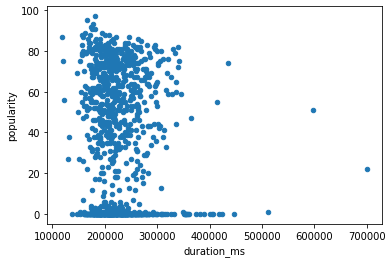

In [9]:
cols = [
    'release_date',
    'track_name',
    'artist_1',
    'artist_2',
    'artist_3',
    'artist_4',
    'artist_5',
    'artist_6',
    'popularity',
    'duration_ms',
    'track_id'
]
favorites_df = favorites_df[cols]

favorites_df.plot.scatter(
    x='duration_ms', y='popularity', 
    xlabel='Duration [ms]', ylabel='Popularity [0-100]'
)

favorites_df

In [10]:
favorites_df.groupby(['artist_1', 'artist_2']).popularity.count()

artist_1      artist_2        
3 Doors Down  Jack Joseph Puig    5
A$AP Rocky    Selena Gomez        1
Akon          Sam Feldt           1
Alan Walker   Noah Cyrus          1
Alessia Cara  Logic               1
                                 ..
benny blanco  Khalid              1
blackbear     Gucci Mane          1
gnash         Olivia O'Brien      1
kai           Flume               1
slowthai      Mura Masa           1
Name: popularity, Length: 266, dtype: int64

In [11]:
favorites_df.groupby('artist_1').popularity.agg([len, min, max])

,len,min,max
artist_1,,,
3 Doors Down,13,0,53
5 Seconds of Summer,2,76,82
A Tribe Called Quest,1,57,57
A$AP Rocky,1,0,0
AC/DC,5,45,61
...,...,...,...
bülow,1,62,62
fun.,1,71,71
gnash,1,80,80
